In [1]:
import os
import sys
sys.path.append("./ddn/")
sys.path.append("./")
import warnings
warnings.filterwarnings('ignore')

import torch
import numpy as np
import scipy.special
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

from scipy.linalg import block_diag
from torch.utils.data import Dataset, DataLoader
#from bernstein import bernstesin_coeff_order10_new
from ddn.pytorch.node import AbstractDeclarativeNode

from utils.viz_helpers import plot_traj
from utils.metrics import get_ade, get_fde

from argoverse.map_representation.map_api import ArgoverseMap
from argoverse.data_loading.argoverse_forecasting_loader import ArgoverseForecastingLoader
from argoverse.visualization.visualize_sequences import viz_sequence
avm = ArgoverseMap()

#### CUDA Initializations

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'cpu'
print('Using {} device'.format(device))

Using cpu device


#### Trajectory DataLoader

In [10]:
from utils.dataloader import TrajectoryDataset

train_dataset = TrajectoryDataset("/datasets/argoverse/val_data.npy", centerline_dir="/datasets/argoverse/val_centerlines.npy")
train_loader = DataLoader(train_dataset, batch_size=20, shuffle=False, num_workers=0)

test_dataset = TrajectoryDataset("/datasets/argoverse/val_test_data.npy", centerline_dir="/datasets/argoverse/val_test_centerlines.npy")
test_loader = DataLoader(test_dataset, batch_size=20, shuffle=False, num_workers=0)

# train_dataset = TrajectoryDataset("/datasets/argoverse/carla_train.npy", t_obs=16)#, centerline_dir="/datasets/argoverse/carla_train_centerlines.npy")
# train_loader = DataLoader(train_dataset, batch_size=20, shuffle=False, num_workers=0)

# test_dataset = TrajectoryDataset("/datasets/argoverse/carla_test.npy",  t_obs=16)#, centerline_dir="/datasets/argoverse/carla_test_centerlines.npy")
# test_loader = DataLoader(test_dataset, batch_size=20, shuffle=False, num_workers=0)

(1000, 50, 2)
AB
(200, 50, 2)
AB


In [39]:
from utils.bernstein import bernstein_coeff_order10_new
# rho_obs = 0.3
rho_obs = 1.2
rho_eq = 10.0
weight_smoothness = 10

num = 30
t_fin = 2.0
a_obs = 1.0
b_obs = 1.0

tot_time = np.linspace(0.0, t_fin, num)
tot_time_copy = tot_time.reshape(num, 1)
P, Pdot, Pddot = bernstein_coeff_order10_new(10, tot_time_copy[0], tot_time_copy[-1], tot_time_copy)
nvar = np.shape(P)[1]

x_obs_temp = np.hstack((-10000.0, 10000.79, 30000.0, 10000.0))
y_obs_temp = np.hstack((-10000.0, 10000.0, -30000.80, 10000.0))

num_obs = np.shape(x_obs_temp)[0]

x_obs = np.ones((num_obs, num)) * x_obs_temp[:, np.newaxis]
y_obs = np.ones((num_obs, num)) * y_obs_temp[:, np.newaxis]

obs_inp_list = []
for i in range(num_obs):
    obs_inp_list.extend([x_obs_temp[i], y_obs_temp[i], a_obs])
    
A_obs = np.tile(P, (num_obs, 1))
A_eq = np.vstack((P[0], Pdot[0], Pddot[0], P[-1], Pdot[-1], Pddot[-1]))
Q_smoothness = np.dot(Pddot.T, Pddot)  

cities = np.load("/datasets/argoverse/val_cities.npy")
offsets_train = np.load("/datasets/argoverse/val_offsets.npy")
# offsets_test = np.load("/datasets/argoverse/val_offsets_test.npy")

#### TrajNet

In [40]:
from utils.nodes.OPTNode import OPTNode, OptLayer, TrajNet

opt_node = OPTNode(
    P, 
    Pddot, 
    A_eq,
    A_obs, 
    Q_smoothness, 
    x_obs,
    y_obs,
    num=num, 
    num_obs=num_obs, 
    nvar=nvar, 
    a_obs=a_obs, 
    b_obs=b_obs, 
    rho_obs=rho_obs, 
    rho_eq=rho_eq,
    weight_smoothness=weight_smoothness, 
    maxiter=300, 
    eps=1e-7, 
    num_tot=num*num_obs
)
opt_layer = OptLayer(opt_node)

num_elems = 15 # number of sampled centerline points
total_size = 20 * 2 + 4 + num_elems * 2
# total_size

model = TrajNet(opt_layer, P, total_size)
model = model.double()
model = model.to(device)

#### Model Testing

In [41]:
x_inp = torch.randn(10, total_size, dtype=torch.double)
y_out = torch.randn(10, 40, dtype=torch.double)
b_inp = torch.randn(10, 12, dtype=torch.double)

print(x_inp.shape)

torch.Size([10, 74])


In [42]:
out = model(x_inp, b_inp)
out.size()

torch.Size([10, 60])

torch.Size([20, 74]) torch.Size([20, 60]) torch.Size([20, 12])
ADE: 19.603165083362228 FDE: 40.17272112644295
torch.Size([20, 74]) torch.Size([20, 60]) torch.Size([20, 12])
ADE: 18.42773453545689 FDE: 38.701253827725786
torch.Size([20, 74]) torch.Size([20, 60]) torch.Size([20, 12])
ADE: 21.527157616533803 FDE: 44.239844726938294
torch.Size([20, 74]) torch.Size([20, 60]) torch.Size([20, 12])
ADE: 19.554590241662478 FDE: 41.81877369571882
torch.Size([20, 74]) torch.Size([20, 60]) torch.Size([20, 12])
ADE: 22.644374880232274 FDE: 47.396573907572325
torch.Size([20, 74]) torch.Size([20, 60]) torch.Size([20, 12])
ADE: 23.505829830668553 FDE: 46.58240334015595
torch.Size([20, 74]) torch.Size([20, 60]) torch.Size([20, 12])
ADE: 20.28159402560973 FDE: 42.09700167186975
torch.Size([20, 74]) torch.Size([20, 60]) torch.Size([20, 12])
ADE: 24.252690010127804 FDE: 50.284617437787084
torch.Size([20, 74]) torch.Size([20, 60]) torch.Size([20, 12])
ADE: 24.240656250379338 FDE: 50.473778319918154
torch.S

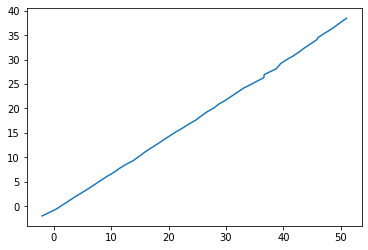

In [44]:
cnt = 0
for i, data in enumerate(train_loader):
    traj_inp, traj_out, b_inp = data
    out = model(traj_inp, b_inp)
    ade = []
    fde = []
#     plt.scatter(traj_inp[0][:32:2], traj_inp[0][1:32:2])
#     plt.scatter(traj_inp[0][32:96:2], traj_inp[0][33:96:2])
    for ii in range(traj_inp.shape[0]):
        gt = [[out[ii][j],out[ii][j + num]] for j in range(len(out[ii])//2)]
        pred = [[traj_out[ii][j],traj_out[ii][j + num]] for j in range(len(out[ii])//2)]
        ade.append(get_ade(np.array(pred), np.array(gt)))
        fde.append(get_fde(np.array(pred), np.array(gt)))
        plot_traj(ii, traj_inp[ii], traj_out[ii], out[ii], {"x": [], "y": []}, offsets=offsets_train, cities = cities, avm=None, center=False, inp_len=20 * 2, c_len = 20 * 2 + num_elems * 2, num=30, mode="test", batch_num = i)
    print(traj_inp.size(), traj_out.size(), b_inp.size())
    print("ADE: {}".format(np.mean(ade)), "FDE: {}".format(np.mean(fde)))
    cnt = cnt + 1
    if cnt > 10000:
        break

#### Training

In [27]:
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.0001)

Epoch: 0, Batch: 0, Loss: 24.008141048699503
ADE: 4.530934032074578 FDE: 10.104133591845653
Epoch: 0, Batch: 10, Loss: 24.259477295818243
ADE: 4.366141756388936 FDE: 9.574554544335612
Epoch: 0, Mean Loss: 15.7871955823869
Mean ADE: 3.4240366046849147 Mean FDE: 7.4354677551476644
----------------------------------------------------------------------------------------------------
Epoch: 1, Batch: 0, Loss: 20.662394408212453
ADE: 4.231356960301994 FDE: 9.332511728223633
Epoch: 1, Batch: 10, Loss: 21.17022581085559
ADE: 4.089264600512158 FDE: 8.961099100348461
Epoch: 1, Mean Loss: 13.85100873129063
Mean ADE: 3.234550087301283 Mean FDE: 6.980317078677108
----------------------------------------------------------------------------------------------------
Epoch: 2, Batch: 0, Loss: 17.788798957896727
ADE: 3.9569648145825718 FDE: 8.686757314355143
Epoch: 2, Batch: 10, Loss: 18.505059028109383
ADE: 3.83613246793226 FDE: 8.428213946291743
Epoch: 2, Mean Loss: 12.219795930937067
Mean ADE: 3.070691

KeyboardInterrupt: 

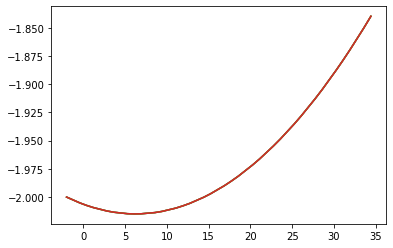

In [31]:
epoch_train_loss = []
num_epochs = 5
ade_total = []
fde_total = []

for epoch in range(num_epochs):
    train_loss = []
    mean_ade = []
    mean_fde = []
    for batch_num, data in enumerate(train_loader):
        traj_inp, traj_out, b_inp = data
        traj_inp = traj_inp.to(device)
        traj_out = traj_out.to(device)
        b_inp = b_inp.to(device)

        out = model(traj_inp, b_inp)
        loss = criterion(out, traj_out)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss.append(loss.item())
        
        cnt = 0
        ade = []
        fde = []       
        for ii in range(traj_inp.size()[0]):
            gt = [[out[ii][j],out[ii][j + num]] for j in range(len(out[ii])//2)]
            pred = [[traj_out[ii][j],traj_out[ii][j + num]] for j in range(len(out[ii])//2)]
            ade.append(get_ade(np.array(pred), np.array(gt)))
            fde.append(get_fde(np.array(pred), np.array(gt)))            
            plot_traj(ii, traj_inp[ii], traj_out[ii], out[ii], {"x": [], "y": []}, offsets=offsets_train, cities = cities, avm=None, center=False, inp_len=num * 2, c_len = num * 2 + num_elems * 2, num=num)
            cnt += 1
        
        if batch_num % 10 == 0:
            print("Epoch: {}, Batch: {}, Loss: {}".format(epoch, batch_num, loss.item()))
            print("ADE: {}".format(np.mean(ade)), "FDE: {}".format(np.mean(fde)))
    
        mean_ade.append(np.mean(ade))
        mean_fde.append(np.mean(fde))
    mean_loss = np.mean(train_loss)
    epoch_train_loss.append(mean_loss)
    ade_total.append(np.mean(mean_ade))
    fde_total.append(np.mean(mean_fde))
    torch.save(model.state_dict(), "./checkpoints/final.ckpt")
    print("Epoch: {}, Mean Loss: {}".format(epoch, mean_loss))
    print("Mean ADE: {}".format(np.mean(mean_ade)), "Mean FDE: {}".format(np.mean(mean_fde)))
    print("-"*100)

#### Testing

Batch: 0, Loss: 21.651967257453663
Batch: 1, Loss: 15.560219082197623
Batch: 2, Loss: 10.759707110224143
Batch: 3, Loss: 9.24195649138094
Batch: 4, Loss: 11.809982725787588
Batch: 5, Loss: 3.8183717961494237
Batch: 6, Loss: 6.875628039191634
Batch: 7, Loss: 11.24518591561262
Batch: 8, Loss: 16.949294095008955
Batch: 9, Loss: 4.990096545232122
Epoch Mean Test Loss: 11.29024090582387
Mean ADE: 2.8959913536681685 Mean FDE: 6.193840370095684


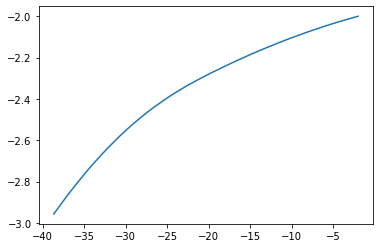

In [32]:
with torch.no_grad():
    test_loss = []
    mean_ade = []
    mean_fde = [] 
    for batch_num, data in enumerate(test_loader):
        traj_inp, traj_out, b_inp = data
        cnt = 0
        traj_inp = traj_inp.to(device)
        traj_out = traj_out.to(device)
        b_inp = b_inp.to(device)

        out = model(traj_inp, b_inp)
        loss = criterion(out, traj_out)
        
        ade = []
        fde = []        
        
        test_loss.append(loss.item())
        obs = np.load("train/obstacle.npy")
        print("Batch: {}, Loss: {}".format(batch_num, loss.item()))
        for ii in range(traj_inp.size()[0]):
            gt = [[out[ii][j],out[ii][j + num]] for j in range(len(out[ii])//2)]
            pred = [[traj_out[ii][j],traj_out[ii][j + num]] for j in range(len(out[ii])//2)]
            ade.append(get_ade(np.array(pred), np.array(gt)))
            fde.append(get_fde(np.array(pred), np.array(gt)))                        
            plot_traj(ii, traj_inp[ii], traj_out[ii], out[ii], {"x": [], "y": []}, offsets=offsets_test, cities = cities, avm=None, center=False, inp_len=num * 2, c_len = num * 2 + num_elems * 2, num=num, mode="test", batch_num=batch_num)
            cnt += 1
        mean_ade.append(np.mean(ade))
        mean_fde.append(np.mean(fde))  
mean_loss = np.mean(test_loss)
print("Epoch Mean Test Loss: {}".format(mean_loss))
print("Mean ADE: {}".format(np.mean(mean_ade)), "Mean FDE: {}".format(np.mean(mean_fde)))

In [ ]:
traj_inp.numpy()[0][:2*num].shape, traj_out.numpy()[0].shape

In [ ]:
traj_inp[6]

In [ ]:
traj_out[6]

In [ ]:
out[6]

In [ ]:
torch.sqrt(torch.sum((traj_out[6] - out[6]) ** 2))

In [ ]:
fin = torch.tensor([traj_out[6][1], traj_out[6][23]])
fin_pred = torch.tensor([out[6][11], out[6][23]])
fin, fin_pred

In [ ]:
torch.sqrt(torch.sum((fin_pred - fin) ** 2))

In [ ]:
torch.sqrt(torch.sum((traj_out[6][-1] - out[6][-1]) ** 2))

In [ ]:
criterion(traj_out[6], out[6])

In [ ]:
def disp_traj(cnt, traj_inp, traj_out, traj_pred):
    traj_inp = traj_inp.numpy()
    traj_out = traj_out.numpy()
    traj_pred = traj_pred.numpy()
    
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    ax.scatter(traj_inp[::2], traj_inp[1::2], label='Inp traj')
    ax.scatter(traj_out[:12], traj_out[12:], label='GT')
    ax.scatter(traj_out[11], traj_out[23], label='Fin GT')
    ax.scatter(traj_pred[:12], traj_pred[12:], label='Pred')
    ax.scatter(traj_pred[11], traj_pred[23], label='Fin Pred')
    
    th = np.linspace(0, 2 * np.pi, 100)
    for i in range(0, num_obs):
        x_circ = x_obs_temp[i] + a_obs * np.cos(th)
        y_circ = y_obs_temp[i] + b_obs * np.sin(th)
        ax.plot(x_circ, y_circ, '-k')
    
    ax.legend()
    ax.set_xlim([-7, 7])
    ax.set_ylim([-7, 7])
    plt.show()

In [ ]:
disp_traj(0, traj_inp[8], traj_out[8], out[8].detach())

In [ ]:
import cvxopt
class OPTNodee(AbstractDeclarativeNode):
    def __init__(self, P, Pddot, A_eq, A_obs, Q_smoothness, x_obs, y_obs, num=12, num_obs=4, nvar=11, a_obs=1.0, b_obs=1.0, rho_obs=0.3, rho_eq=10.0, weight_smoothness=10, maxiter=300, eps=1e-7, num_tot=48):
        super().__init__()
        self.P = torch.tensor(P, dtype=torch.double).to(device)
        self.Pddot = torch.tensor(Pddot, dtype=torch.double).to(device)
        self.A_eq = torch.tensor(A_eq, dtype=torch.double).to(device)
        self.A_obs = torch.tensor(A_obs, dtype=torch.double).to(device)
        self.Q_smoothness = torch.tensor(Q_smoothness, dtype=torch.double).to(device)
        self.x_obs = torch.tensor(x_obs, dtype=torch.double).to(device)
        self.y_obs = torch.tensor(y_obs, dtype=torch.double).to(device)
        
        self.num = num
        self.num_obs = num_obs
        self.eps = eps
        self.nvar = nvar        
        self.a_obs = a_obs
        self.b_obs = b_obs        
        self.rho_eq = rho_eq
        self.num_obs = num_obs
        self.maxiter = maxiter
        self.num_tot = num_tot
        self.rho_obs = rho_obs
        self.weight_smoothness = weight_smoothness
        
    def objective(self, b, lamda_x, lamda_y, y):  
        batch_size, _ = b.size()
        b = b.transpose(0, 1)
        y = y.transpose(0, 1)
        lamda_x = lamda_x.transpose(0, 1)
        lamda_y = lamda_y.transpose(0, 1)
        bx_eq_tensor, by_eq_tensor = torch.split(b, 6, dim=0)
        ones_tensor = torch.ones(self.num_tot, batch_size, dtype=torch.double).to(device)

        c_x = y[0:self.nvar]
        c_y = y[self.nvar:2 * self.nvar]
        alpha_obs = y[2 * self.nvar: 2 * self.nvar + self.num_tot]
        d_obs = y[2 * self.nvar + self.num_tot:]

        cost_smoothness_x = 0.5 * self.weight_smoothness * torch.diag(torch.matmul(c_x.T, torch.matmul(self.Q_smoothness, c_x)))
        cost_smoothness_y = 0.5 * self.weight_smoothness * torch.diag(torch.matmul(c_y.T, torch.matmul(self.Q_smoothness, c_y)))

        temp_x_obs = d_obs * torch.cos(alpha_obs) * self.a_obs
        b_obs_x = self.x_obs.view(-1, 1) + temp_x_obs

        temp_y_obs = d_obs * torch.sin(alpha_obs) * self.b_obs
        b_obs_y = self.y_obs.view(-1, 1) + temp_y_obs

        cost_obs_x = 0.5 * self.rho_obs * (torch.sum((torch.matmul(self.A_obs, c_x) - b_obs_x) ** 2, axis=0))
        cost_obs_y = 0.5 * self.rho_obs * (torch.sum((torch.matmul(self.A_obs, c_y) - b_obs_y) ** 2, axis=0))
        cost_slack = self.rho_obs * torch.sum(torch.max(1 - d_obs, ones_tensor), axis=0)

        cost_eq_x = 0.5 * self.rho_eq * torch.sum((torch.matmul(self.A_eq, c_x) - bx_eq_tensor) ** 2, axis=0)
        cost_eq_y = 0.5 * self.rho_eq * torch.sum((torch.matmul(self. A_eq, c_y) - by_eq_tensor) ** 2, axis=0)

        cost_x = cost_smoothness_x + cost_obs_x + cost_eq_x
        cost_y = cost_smoothness_y + cost_obs_y + cost_eq_y
        cost = cost_x + cost_y + self.eps * torch.sum(c_x ** 2, axis=0) + self.eps * torch.sum(c_y ** 2, axis=0) + self.eps * torch.sum(d_obs ** 2, axis=0) + self.eps * torch.sum(alpha_obs ** 2, axis=0) + cost_slack
        return cost

    def optimize(self, b, lamda_x, lamda_y):
        bx_eq_tensor, by_eq_tensor = torch.split(b, 6, dim=0)
        
        d_obs = torch.ones(self.num_obs, self.num, dtype=torch.double).to(device)
        alpha_obs = torch.zeros(self.num_obs, self.num, dtype=torch.double).to(device)
        ones_tensor = torch.ones((self.num_obs, self.num), dtype=torch.double).to(device)
        cost_smoothness = self.weight_smoothness * torch.matmul(self.Pddot.T, self.Pddot)
        cost = cost_smoothness + self.rho_obs * torch.matmul(self.A_obs.T, self.A_obs) + self.rho_eq * torch.matmul(self.A_eq.T, self.A_eq)

        temp_x_obs = d_obs * torch.cos(alpha_obs) * self.a_obs
        temp_y_obs = d_obs * torch.sin(alpha_obs) * self.b_obs

        b_obs_x = self.x_obs.view(self.num * self.num_obs) + temp_x_obs.view(self.num * self.num_obs)
        b_obs_y = self.y_obs.view(self.num * self.num_obs) + temp_y_obs.view(self.num * self.num_obs)        
        
        bx_eq_tensor, by_eq_tensor = torch.split(b, 6, dim=0)
        
#         + torch.matmul(self.A_obs.T, b_obs_x) + self.rho_eq * torch.matmul(self.A_eq.T, bx_eq_tensor)
#          self.rho_obs * torch.matmul(self.A_obs.T, b_obs_y) - self.rho_eq * torch.matmul(self.A_eq.T, by_eq_tensor)        
        
#       A_eq = np.vstack((P[0], Pdot[0], Pddot[0], P[-1], Pdot[-1], Pddot[-1]))
#       A_eq = np.vstack((A_eq, A_eq))
#        A_obs = np.tile(P, (num_obs, 1))
        b_eq = np.hstack((bx_eq_tensor, by_eq_tensor))
#         print(A_obs.shape)
#         A_eq = np.vstack((P[0], Pdot[0], Pddot[0], P[-1], Pdot[-1], Pddot[-1]))
        Q_obs = torch.matmul(self.A_obs.T, self.A_obs)
        Q_eq = torch.matmul(self.A_eq.T, self.A_eq)
        bx_obs = x_obs.reshape(num_obs * num)
        by_obs = y_obs.reshape(num_obs * num)
        qx_obs = torch.matmul(b_obs_x.T, self.A_obs) * 2
        qy_obs = torch.matmul(b_obs_y.T, self.A_obs) * 2
        qx_eq = torch.matmul(bx_eq_tensor.T, self.A_eq) * 2
        qy_eq = torch.matmul(by_eq_tensor.T, self.A_eq) * 2
        q = np.hstack((qx_eq, qy_eq))
#         print(Q_obs.shape)
        AA_eq = cvxopt.matrix(self.A_eq, tc='d')
        bx_eq = cvxopt.matrix(bx_eq_tensor, tc='d')
        by_eq = cvxopt.matrix(by_eq_tensor, tc='d')
        b_eq = cvxopt.matrix(b_eq, tc='d')
        Q = cvxopt.matrix(cost, tc='d')
        q_x = cvxopt.matrix(rho_obs * qx_obs + rho_eq * qx_eq)
        q_y = cvxopt.matrix(rho_obs * qy_obs + rho_eq * qy_eq)
        sol_x = solvers.qp(Q, q_x, None, None, AA_eq, bx_eq)
        sol_x = torch.tensor(sol_x['x'])
        sol_y = solvers.qp(Q, q_y, None, None, AA_eq, by_eq)
        sol_y = torch.tensor(sol_y['x'])
        sol = torch.cat([sol_x, sol_y, alpha_obs.view(-1), d_obs.view(-1)])
        return sol

    def solve(self, b, lamda_x, lamda_y):
        batch_size, _ = b.size()
        b = b.transpose(0, 1)
        lamda_x = lamda_x.transpose(0, 1)
        lamda_y = lamda_y.transpose(0, 1)
        y = torch.zeros(batch_size, 2 * self.nvar + 2 * self.num_tot, dtype=torch.double).to(device)
        for i in range(batch_size):
            b_cur = b[:, i]
            lamda_x_cur = lamda_x[:, i]
            lamda_y_cur = lamda_y[:, i]
            sol = self.optimize(b_cur, lamda_x_cur, lamda_y_cur)
            y[i, :] = sol
        return y, None

In [8]:
import numpy as np
import matplotlib.pyplot as plt
arr = np.load("carla_test.npy")
arr.shape

(193, 32, 6)

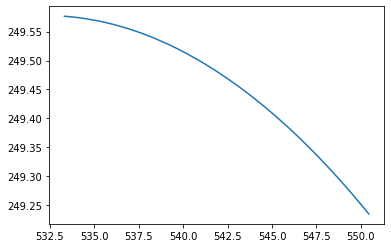

In [12]:
arr[0,:,:4].shape
plt.plot(arr[3, :, 0], arr[3, :, 1])